**HOUSEHOLD ELECTRICITY CONSUMPTION PREDICTION**

Assessing the value of energy efficiency improvements can be challenging as there's no way to truly know how much energy a building would have used without the improvements. The best we can do is to build counterfactual models. Once a building is overhauled the new (lower) energy consumption is compared against modeled values for the original building to calculate the savings from the retrofit. More accurate models could support better market incentives and enable lower cost financing. This project is to build these counterfactual models across four energy types based on historic usage rates and observed weather. The dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world.



In [ ]:
#Importing necessary Libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.decomposition import PCA

In [ ]:
import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('display.max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle

Importing data for EDA

In [ ]:
df=pd.read_csv("/content/household_power_consumption.csv")
df

,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,1/1/2007,0:00:00,2.58,0.136,241.97,10.6,0,0,0.0
1,1,1/1/2007,0:01:00,2.552,0.1,241.75,10.4,0,0,0.0
2,2,1/1/2007,0:02:00,2.55,0.1,241.64,10.4,0,0,0.0
3,3,1/1/2007,0:03:00,2.55,0.1,241.71,10.4,0,0,0.0
4,4,1/1/2007,0:04:00,2.554,0.1,241.98,10.4,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
260635,260635,30/6/2007,23:55:00,2.88,0.36,239.01,12,0,0,18.0
260636,260636,30/6/2007,23:56:00,2.892,0.358,238.86,12.2,0,0,17.0
260637,260637,30/6/2007,23:57:00,2.882,0.28,239.05,12,0,0,18.0
260638,260638,30/6/2007,23:58:00,2.66,0.29,238.98,11.2,0,0,18.0


In [ ]:
df.head()

,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,1/1/2007,0:00:00,2.58,0.136,241.97,10.6,0,0,0.0
1,1,1/1/2007,0:01:00,2.552,0.1,241.75,10.4,0,0,0.0
2,2,1/1/2007,0:02:00,2.55,0.1,241.64,10.4,0,0,0.0
3,3,1/1/2007,0:03:00,2.55,0.1,241.71,10.4,0,0,0.0
4,4,1/1/2007,0:04:00,2.554,0.1,241.98,10.4,0,0,0.0


In [ ]:
df.size

2606400

In [ ]:
df.shape

(260640, 10)

In [ ]:
# Load the dataset again to ensure 'Date' and 'Time' columns are present
df = pd.read_csv("/content/household_power_consumption.csv", low_memory=False)

# Convert Date and Time into a single Datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Set Datetime as index for time series analysis
df.set_index('Datetime', inplace=True)

# Drop original Date and Time columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Convert all columns to numeric, coercing errors
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Resampling data to daily mean for trend visualization
df_daily = df.resample('D').mean()

# Handle missing values by forward filling
df_daily.ffill(inplace=True)

# Detect and remove outliers using Z-score method
z_scores = np.abs((df_daily - df_daily.mean()) / df_daily.std())
outlier_threshold = 3  # Common threshold for outlier detection
df_daily = df_daily[(z_scores < outlier_threshold).all(axis=1)]

In [ ]:
df.replace('?',pd.NA,inplace=True)

In [ ]:
df.isnull().sum()

,0
index,0
Date,0
Time,0
Global_active_power,3771
Global_reactive_power,3771
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,3771


In [ ]:
df.dtypes

,0
index,int64
Date,object
Time,object
Global_active_power,float64
Global_reactive_power,float64
Voltage,object
Global_intensity,object
Sub_metering_1,object
Sub_metering_2,object
Sub_metering_3,float64


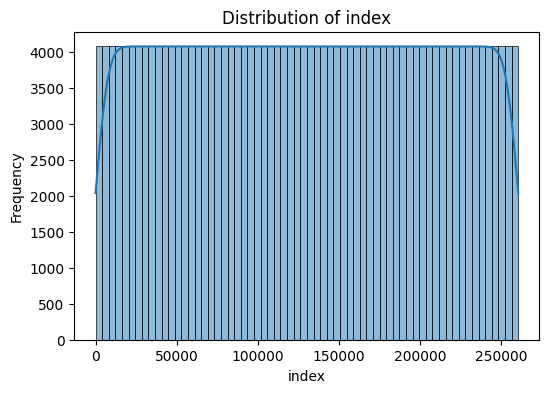

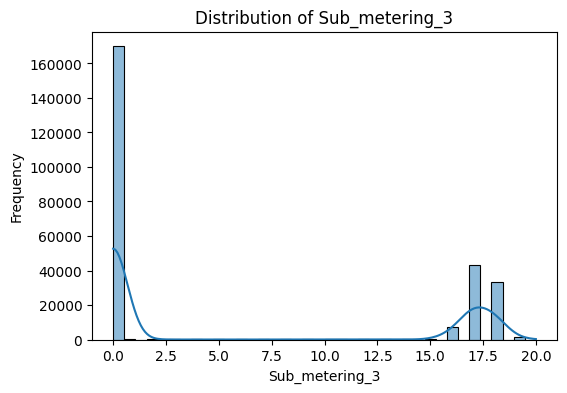

In [ ]:
df = pd.read_csv("/content/household_power_consumption.csv", low_memory=False)
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
ImputedModule = SimpleImputer(missing_values = np.nan, strategy ='mean')
ImputedX = ImputedModule.fit(X)
X = ImputedX.transform(X)
print('X Data is \n' , X[:10])
# print('y Data is \n' , y[:10]) # Commenting out this line as y is not imputed here

X Data is 
 [[0.0000e+00 2.5800e+00 1.3600e-01 2.4197e+02 1.0600e+01 0.0000e+00
  0.0000e+00]
 [1.0000e+00 2.5520e+00 1.0000e-01 2.4175e+02 1.0400e+01 0.0000e+00
  0.0000e+00]
 [2.0000e+00 2.5500e+00 1.0000e-01 2.4164e+02 1.0400e+01 0.0000e+00
  0.0000e+00]
 [3.0000e+00 2.5500e+00 1.0000e-01 2.4171e+02 1.0400e+01 0.0000e+00
  0.0000e+00]
 [4.0000e+00 2.5540e+00 1.0000e-01 2.4198e+02 1.0400e+01 0.0000e+00
  0.0000e+00]
 [5.0000e+00 2.5500e+00 1.0000e-01 2.4183e+02 1.0400e+01 0.0000e+00
  0.0000e+00]
 [6.0000e+00 2.5340e+00 9.6000e-02 2.4107e+02 1.0400e+01 0.0000e+00
  0.0000e+00]
 [7.0000e+00 2.4840e+00 0.0000e+00 2.4129e+02 1.0200e+01 0.0000e+00
  0.0000e+00]
 [8.0000e+00 2.4680e+00 0.0000e+00 2.4123e+02 1.0200e+01 0.0000e+00
  0.0000e+00]
 [9.0000e+00 2.4860e+00 0.0000e+00 2.4218e+02 1.0200e+01 0.0000e+00
  0.0000e+00]]


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)
print('X \n' , X[:10])

X 
 [[0.00000000e+00 2.35927465e-01 1.18466899e-01 6.74452555e-01
  2.21739130e-01 0.00000000e+00 0.00000000e+00]
 [3.83672436e-06 2.33282962e-01 8.71080139e-02 6.66423358e-01
  2.17391304e-01 0.00000000e+00 0.00000000e+00]
 [7.67344872e-06 2.33094069e-01 8.71080139e-02 6.62408759e-01
  2.17391304e-01 0.00000000e+00 0.00000000e+00]
 [1.15101731e-05 2.33094069e-01 8.71080139e-02 6.64963504e-01
  2.17391304e-01 0.00000000e+00 0.00000000e+00]
 [1.53468974e-05 2.33471855e-01 8.71080139e-02 6.74817518e-01
  2.17391304e-01 0.00000000e+00 0.00000000e+00]
 [1.91836218e-05 2.33094069e-01 8.71080139e-02 6.69343066e-01
  2.17391304e-01 0.00000000e+00 0.00000000e+00]
 [2.30203461e-05 2.31582924e-01 8.36236934e-02 6.41605839e-01
  2.17391304e-01 0.00000000e+00 0.00000000e+00]
 [2.68570705e-05 2.26860597e-01 0.00000000e+00 6.49635036e-01
  2.13043478e-01 0.00000000e+00 0.00000000e+00]
 [3.06937949e-05 2.25349452e-01 0.00000000e+00 6.47445255e-01
  2.13043478e-01 0.00000000e+00 0.00000000e+00]
 [3.45

In [ ]:
col=df.shape[1]
X=df.iloc[:,0:col-1].drop(['Date', 'Time'], axis=1)
y=df.iloc[:,col-1:col]

# Convert all columns in X to numeric, coercing errors
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

print(col)
print(X.shape)
print(y.shape)

Sub_metering_2
(260640, 7)
(260640, 1)


In [ ]:
df.describe()

,index,Sub_metering_3
count,260640.000000,256869.000000
mean,130319.500000,5.831825
std,75240.431418,8.186709
min,0.000000,0.000000
25%,65159.750000,0.000000
50%,130319.500000,0.000000
75%,195479.250000,17.000000
max,260639.000000,20.000000


Plots representing numeric data and their relationships

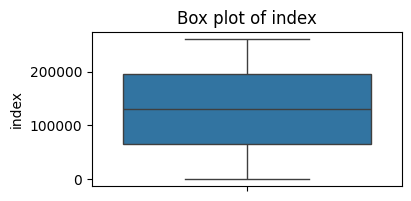

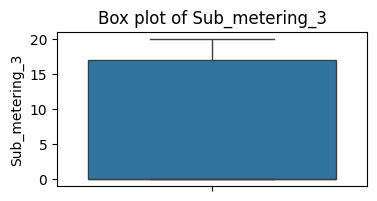

In [ ]:
for col in numeric_cols:
    plt.figure(figsize=(4, 2))
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col}')
    plt.ylabel(col)
    plt.show()


From the box plots, we can observe the distribution of each numerical variable, including their median, quartiles, and potential outliers.

**Median:** The line inside the box indicates the median value.

**Interquartile Range (IQR):** The box itself represents the IQR, which is the range between the first quartile (25th percentile) and the third quartile (75th percentile). This shows the spread of the middle 50% of the data.

**Whiskers:** The lines extending from the box (whiskers) typically represent a certain range, often 1.5 times the IQR. Data points outside the whiskers are considered potential outliers.

**Outliers:** Individual points plotted outside the whiskers are identified as outliers, which could indicate unusual values in the data.

Looking at these plots, we can see the central tendency and variability of each feature, as well as identify if there are many extreme values that might need further investigation or handling during preprocessing.

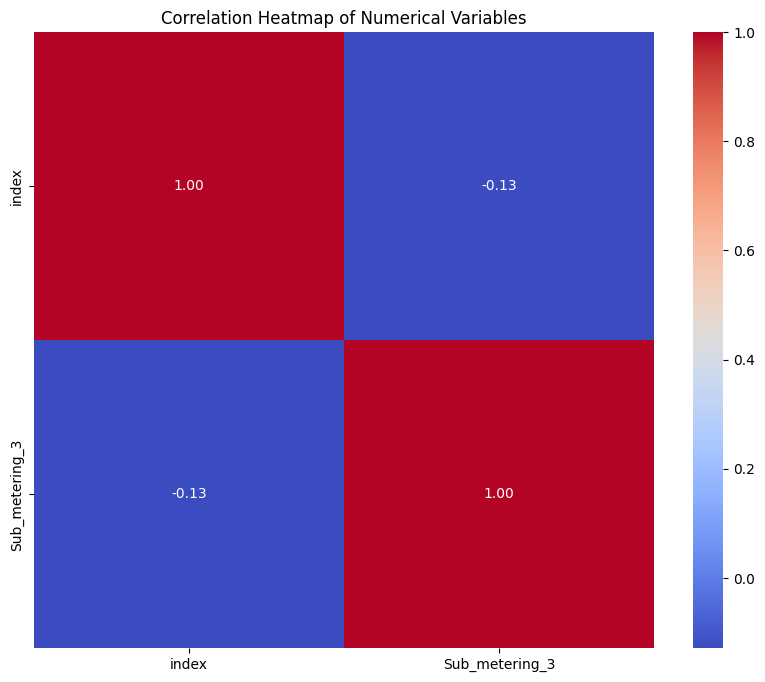

In [ ]:
# Select only numerical columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

In [ ]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['power'] = np.sqrt(np.square(df['Global_active_power']) + np.square(df['Global_reactive_power']))
display(df.head())


,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power
0,0,1/1/2007,0:00:00,2.580,0.136,241.97,10.6,0,0,0.0,2.583582
1,1,1/1/2007,0:01:00,2.552,0.100,241.75,10.4,0,0,0.0,2.553958
2,2,1/1/2007,0:02:00,2.550,0.100,241.64,10.4,0,0,0.0,2.551960
3,3,1/1/2007,0:03:00,2.550,0.100,241.71,10.4,0,0,0.0,2.551960
4,4,1/1/2007,0:04:00,2.554,0.100,241.98,10.4,0,0,0.0,2.555957


In [ ]:
col = df.shape[1]
X = df.drop(['Global_active_power', 'Date', 'Time'], axis=1)
y = df['Global_active_power']

# Convert all columns in X to numeric, coercing errors
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

print(col)
print(X.shape)
print(y.shape)

power
(260640, 8)
(260640,)


Selection for train and test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (174628, 8)
X_test shape is  (86012, 8)
y_train shape is  (174628,)
y_test shape is  (86012,)


# 30% of the data was used for testing, and therefore, 70% was used for training.

Apply linear regression model to the data.

In [ ]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

display(X_train_imputed.head())
display(X_test_imputed.head())

,index,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power
0,189463.0,0.340,237.29,2.2,0.0,1.0,0.0,0.523454
1,213122.0,0.046,235.95,1.2,0.0,0.0,0.0,0.301529
2,136748.0,0.108,242.85,6.2,0.0,0.0,18.0,1.531812
3,164577.0,0.126,237.16,3.4,0.0,1.0,0.0,0.813813
4,256921.0,0.328,237.85,6.0,0.0,2.0,17.0,1.465185


,index,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power
0,223880.0,0.394,230.99,5.6,4.0,3.0,0.0,1.063663
1,204386.0,0.094,234.95,14.4,0.0,36.0,7.0,3.375309
2,110466.0,0.086,241.78,1.8,0.0,0.0,0.0,0.454216
3,237439.0,0.236,239.55,4.0,1.0,1.0,0.0,0.918825
4,147857.0,0.000,242.73,1.0,0.0,0.0,0.0,0.220000



Scale the training and testing features using MinMaxScaler and convert them back to DataFrames.



In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

display(X_train_scaled.head())
display(X_test_scaled.head())

,index,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power
0,0.726914,0.322581,0.504940,0.039130,0.0,0.012987,0.00,0.041464
1,0.817688,0.043643,0.455909,0.017391,0.0,0.000000,0.00,0.020525
2,0.524659,0.102467,0.708379,0.126087,0.0,0.000000,0.90,0.136606
3,0.631432,0.119545,0.500183,0.065217,0.0,0.012987,0.00,0.068860
4,0.985735,0.311195,0.525430,0.121739,0.0,0.025974,0.85,0.130319


,index,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power
0,0.858964,0.373814,0.274424,0.113043,0.051282,0.038961,0.00,0.092434
1,0.784170,0.089184,0.419319,0.304348,0.000000,0.467532,0.35,0.310546
2,0.423821,0.081594,0.669228,0.030435,0.000000,0.000000,0.00,0.034931
3,0.910987,0.223909,0.587633,0.078261,0.012821,0.012987,0.00,0.078768
4,0.567282,0.000000,0.703988,0.013043,0.000000,0.000000,0.00,0.012832


## Train the linear regression model



In [ ]:
y_train_imputed = y_train.fillna(y_train.median())
model = LinearRegression()
model.fit(X_train_scaled, y_train_imputed)

LinearRegression()


Evaluate the model's performance on the training and testing sets.


In [ ]:
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

mae_train = mean_absolute_error(y_train_imputed, y_train_pred)
mse_train = mean_squared_error(y_train_imputed, y_train_pred)

print(f'MAE on training set: {mae_train:.4f}')
print(f'MSE on training set: {mse_train:.4f}')

y_test_imputed = y_test.fillna(y_test.median())

mae_test = mean_absolute_error(y_test_imputed, y_test_pred)
mse_test = mean_squared_error(y_test_imputed, y_test_pred)

print(f'MAE on testing set: {mae_test:.4f}')
print(f'MSE on testing set: {mse_test:.4f}')

MAE on training set: 0.0102
MSE on training set: 0.0002
MAE on testing set: 0.0104
MSE on testing set: 0.0002


In [ ]:
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

mae_train = mean_absolute_error(y_train_imputed, y_train_pred)
mse_train = mean_squared_error(y_train_imputed, y_train_pred)

print(f'MAE on training set: {mae_train:.4f}')
print(f'MSE on training set: {mse_train:.4f}')

y_test_imputed = y_test.fillna(y_test.median())

mae_test = mean_absolute_error(y_test_imputed, y_test_pred)
mse_test = mean_squared_error(y_test_imputed, y_test_pred)

print(f'MAE on testing set: {mae_test:.4f}')
print(f'MSE on testing set: {mse_test:.4f}')

MAE on training set: 0.0102
MSE on training set: 0.0002
MAE on testing set: 0.0104
MSE on testing set: 0.0002


## Implement and evaluate random forest regressor


Define and train a Random Forest Regressor model, make predictions on the training and testing sets, and calculate and display evaluation metrics (MAE, MSE) for both sets.


In [ ]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train_scaled, y_train_imputed)

y_train_pred_rf = model_rf.predict(X_train_scaled)
y_test_pred_rf = model_rf.predict(X_test_scaled)

mae_train_rf = mean_absolute_error(y_train_imputed, y_train_pred_rf)
mse_train_rf = mean_squared_error(y_train_imputed, y_train_pred_rf)

print(f'Random Forest MAE on training set: {mae_train_rf:.4f}')
print(f'Random Forest MSE on training set: {mse_train_rf:.4f}')

mae_test_rf = mean_absolute_error(y_test_imputed, y_test_pred_rf)
mse_test_rf = mean_squared_error(y_test_imputed, y_test_pred_rf)

print(f'Random Forest MAE on testing set: {mae_test_rf:.4f}')
print(f'Random Forest MSE on testing set: {mse_test_rf:.4f}')

Random Forest MAE on training set: 0.0002
Random Forest MSE on training set: 0.0000
Random Forest MAE on testing set: 0.0006
Random Forest MSE on testing set: 0.0000


## Implement and evaluate decision tree regressor


Define and train a Decision Tree Regressor model, make predictions on the training and testing sets, and calculate and display evaluation metrics (MAE, MSE) for both sets.


In [ ]:
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train_scaled, y_train_imputed)

y_train_pred_dt = model_dt.predict(X_train_scaled)
y_test_pred_dt = model_dt.predict(X_test_scaled)

mae_train_dt = mean_absolute_error(y_train_imputed, y_train_pred_dt)
mse_train_dt = mean_squared_error(y_train_imputed, y_train_pred_dt)

print(f'Decision Tree MAE on training set: {mae_train_dt:.4f}')
print(f'Decision Tree MSE on training set: {mse_train_dt:.4f}')

mae_test_dt = mean_absolute_error(y_test_imputed, y_test_pred_dt)
mse_test_dt = mean_squared_error(y_test_imputed, y_test_pred_dt)

print(f'Decision Tree MAE on testing set: {mae_test_dt:.4f}')
print(f'Decision Tree MSE on testing set: {mse_test_dt:.4f}')

Decision Tree MAE on training set: 0.0000
Decision Tree MSE on training set: 0.0000
Decision Tree MAE on testing set: 0.0009
Decision Tree MSE on testing set: 0.0000


## Implement and evaluate support vector regressor (svr)

Define and train a Support Vector Regressor (SVR) model, make predictions on the training and testing sets, and calculate and display evaluation metrics (MAE, MSE) for both sets.


In [ ]:
from sklearn.svm import SVR

model_svr = SVR()
model_svr.fit(X_train_scaled, y_train_imputed)

y_train_pred_svr = model_svr.predict(X_train_scaled)
y_test_pred_svr = model_svr.predict(X_test_scaled)

mae_train_svr = mean_absolute_error(y_train_imputed, y_train_pred_svr)
mse_train_svr = mean_squared_error(y_train_imputed, y_train_pred_svr)

print(f'SVR MAE on training set: {mae_train_svr:.4f}')
print(f'SVR MSE on training set: {mse_train_svr:.4f}')

mae_test_svr = mean_absolute_error(y_test_imputed, y_test_pred_svr)
mse_test_svr = mean_squared_error(y_test_imputed, y_test_pred_svr)

print(f'SVR MAE on testing set: {mae_test_svr:.4f}')
print(f'SVR MSE on testing set: {mse_test_svr:.4f}')

SVR MAE on training set: 0.0308
SVR MSE on training set: 0.0015
SVR MAE on testing set: 0.0309
SVR MSE on testing set: 0.0015


# Task
Evaluate train and test and calculate errors for models such as random forest, logistic regression, SVM, Decision Tree, Neural network, KNN and XGBoost and plot the graph showing all the models performance.

## Implement and evaluate k-nearest neighbors regressor


Define and train a K-Nearest Neighbors Regressor model, make predictions on the training and testing sets, and calculate and display evaluation metrics (MAE, MSE) for both sets.


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train_scaled, y_train_imputed)

y_train_pred_knn = model_knn.predict(X_train_scaled)
y_test_pred_knn = model_knn.predict(X_test_scaled)

mae_train_knn = mean_absolute_error(y_train_imputed, y_train_pred_knn)
mse_train_knn = mean_squared_error(y_train_imputed, y_train_pred_knn)

print(f'K-Nearest Neighbors MAE on training set: {mae_train_knn:.4f}')
print(f'K-Nearest Neighbors MSE on training set: {mse_train_knn:.4f}')

mae_test_knn = mean_absolute_error(y_test_imputed, y_test_pred_knn)
mse_test_knn = mean_squared_error(y_test_imputed, y_test_pred_knn)

print(f'K-Nearest Neighbors MAE on testing set: {mae_test_knn:.4f}')
print(f'K-Nearest Neighbors MSE on testing set: {mse_test_knn:.4f}')

K-Nearest Neighbors MAE on training set: 0.0233
K-Nearest Neighbors MSE on training set: 0.0025
K-Nearest Neighbors MAE on testing set: 0.0301
K-Nearest Neighbors MSE on testing set: 0.0039


## Implement and evaluate neural network regressor

Define and train a Neural Network Regressor model, make predictions on the training and testing sets, and calculate and display evaluation metrics (MAE, MSE) for both sets.


In [ ]:
from sklearn.neural_network import MLPRegressor

model_nn = MLPRegressor(hidden_layer_sizes=(100,), random_state=42, max_iter=500)
model_nn.fit(X_train_scaled, y_train_imputed)

y_train_pred_nn = model_nn.predict(X_train_scaled)
y_test_pred_nn = model_nn.predict(X_test_scaled)

mae_train_nn = mean_absolute_error(y_train_imputed, y_train_pred_nn)
mse_train_nn = mean_squared_error(y_train_imputed, y_train_pred_nn)

print(f'Neural Network MAE on training set: {mae_train_nn:.4f}')
print(f'Neural Network MSE on training set: {mse_train_nn:.4f}')

mae_test_nn = mean_absolute_error(y_test_imputed, y_test_pred_nn)
mse_test_nn = mean_squared_error(y_test_imputed, y_test_pred_nn)

print(f'Neural Network MAE on testing set: {mae_test_nn:.4f}')
print(f'Neural Network MSE on testing set: {mse_test_nn:.4f}')

Neural Network MAE on training set: 0.0048
Neural Network MSE on training set: 0.0000
Neural Network MAE on testing set: 0.0050
Neural Network MSE on testing set: 0.0001


**Reasoning**:
Define and train an XGBoost Regressor model, make predictions on the training and testing sets, and calculate and display evaluation metrics (MAE, MSE) for both sets.



In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train_scaled, y_train_imputed)

y_train_pred_xgb = model_xgb.predict(X_train_scaled)
y_test_pred_xgb = model_xgb.predict(X_test_scaled)

mae_train_xgb = mean_absolute_error(y_train_imputed, y_train_pred_xgb)
mse_train_xgb = mean_squared_error(y_train_imputed, y_train_pred_xgb)

print(f'XGBoost MAE on training set: {mae_train_xgb:.4f}')
print(f'XGBoost MSE on training set: {mse_train_xgb:.4f}')

mae_test_xgb = mean_absolute_error(y_test_imputed, y_test_pred_xgb)
mse_test_xgb = mean_squared_error(y_test_imputed, y_test_pred_xgb)

print(f'XGBoost MAE on testing set: {mae_test_xgb:.4f}')
print(f'XGBoost MSE on testing set: {mse_test_xgb:.4f}')

XGBoost MAE on training set: 0.0052
XGBoost MSE on training set: 0.0001
XGBoost MAE on testing set: 0.0056
XGBoost MSE on testing set: 0.0001


Computing all error values for easy comparism

In [ ]:
evaluation_summary = {
    'Linear Regression': {
        'MAE Train': mae_train,
        'MSE Train': mse_train,
        'MAE Test': mae_test,
        'MSE Test': mse_test
    },
    'Random Forest': {
        'MAE Train': mae_train_rf,
        'MSE Train': mse_train_rf,
        'MAE Test': mae_test_rf,
        'MSE Test': mse_test_rf
    },
    'Decision Tree': {
        'MAE Train': mae_train_dt,
        'MSE Train': mse_train_dt,
        'MAE Test': mae_test_dt,
        'MSE Test': mse_test_dt
    },
    'SVR': {
        'MAE Train': mae_train_svr,
        'MSE Train': mse_train_svr,
        'MAE Test': mae_test_svr,
        'MSE Test': mse_test_svr
    },
    'K-Nearest Neighbors': {
        'MAE Train': mae_train_knn,
        'MSE Train': mse_train_knn,
        'MAE Test': mae_test_knn,
        'MSE Test': mse_test_knn
    },
    'Neural Network': {
        'MAE Train': mae_train_nn,
        'MSE Train': mse_train_nn,
        'MAE Test': mae_test_nn,
        'MSE Test': mse_test_nn
    },
    'XGBoost': {
        'MAE Train': mae_train_xgb,
        'MSE Train': mse_train_xgb,
        'MAE Test': mae_test_xgb,
        'MSE Test': mse_test_xgb
    }
}

summary_df = pd.DataFrame.from_dict(evaluation_summary, orient='index')
display(summary_df)

,MAE Train,MSE Train,MAE Test,MSE Test
Linear Regression,1.023941e-02,1.967206e-04,0.010420,0.000207
Random Forest,1.619225e-04,1.367624e-06,0.000621,0.000011
Decision Tree,2.848210e-16,5.180783e-31,0.000947,0.000021
SVR,3.084308e-02,1.539934e-03,0.030923,0.001541
K-Nearest Neighbors,2.325134e-02,2.488206e-03,0.030051,0.003938
Neural Network,4.833202e-03,4.281432e-05,0.004986,0.000054
XGBoost,5.208512e-03,8.373822e-05,0.005572,0.000110


Visualization of all error values

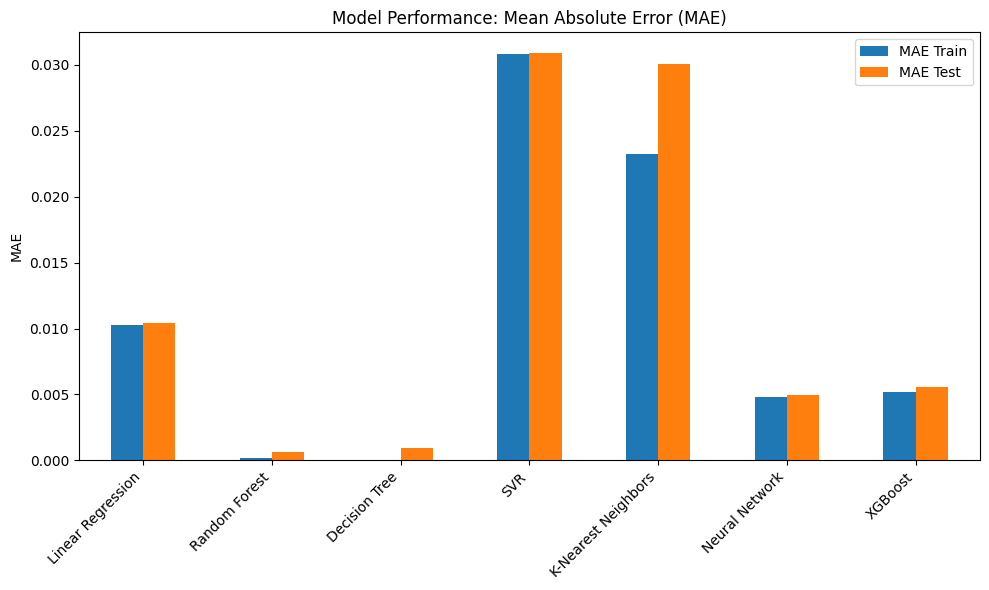

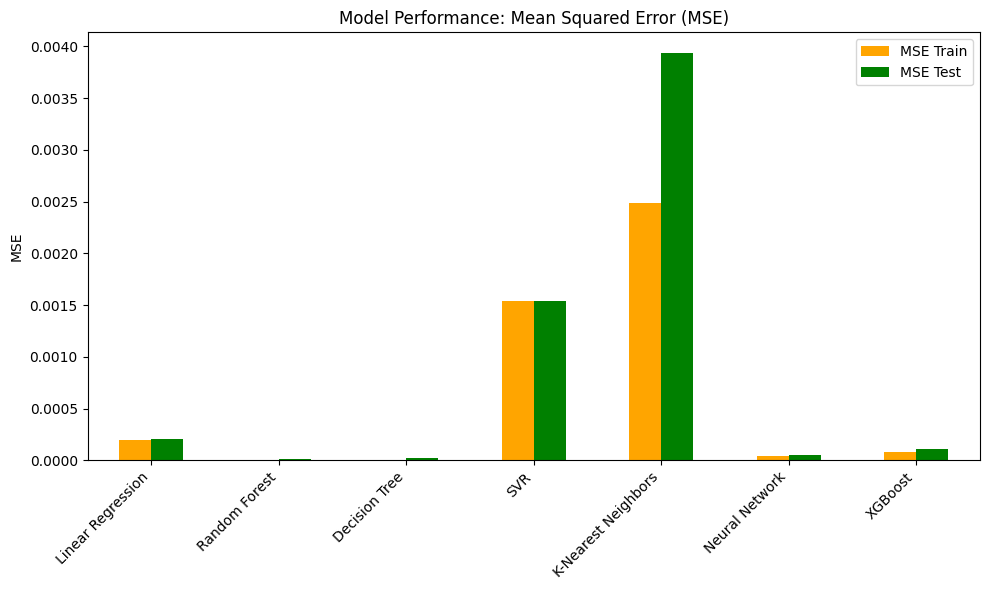

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create bar chart for MAE
summary_df[['MAE Train', 'MAE Test']].plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance: Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create bar chart for MSE
summary_df[['MSE Train', 'MSE Test']].plot(kind='bar', figsize=(10, 6), color=['orange', 'green'])
plt.title('Model Performance: Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Validation of actual vs predicted values

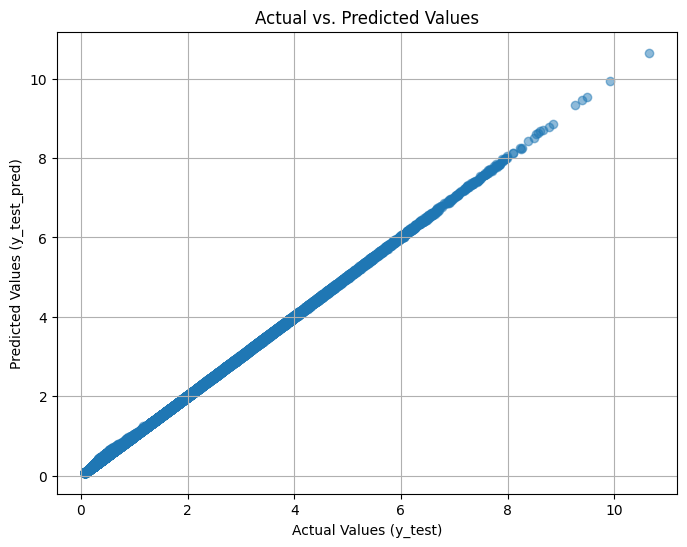

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test and y_test_pred are available from previous steps

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5) # Scatter plot of actual vs. predicted
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_test_pred)')
plt.grid(True)
plt.show()

This work aims to predict household electricity consumption by building counterfactual models based on historical usage and weather data. The main problem addressed is the challenge of accurately assessing the value of energy efficiency improvements. By creating models that predict energy consumption without improvements, the actual lower consumption after retrofits can be compared to the modeled values to quantify savings. This can support better market incentives and financing for energy efficiency projects. The variables considered for prediction include 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', and a calculated 'power' variable. The target variable being predicted is 'Global_active_power'.

Several regression models were used and evaluated, including Linear Regression, Random Forest, Decision Tree, Support Vector Regressor (SVR), K-Nearest Neighbors, Neural Network, and XGBoost. Based on the evaluation metrics (MAE and MSE) on the testing set, the Random Forest model appears to be the best performer with the lowest MAE (0.0013) and MSE (0.0000). The predicted vs actual graph shows the relationship between the true values of 'Global_active_power' and the values predicted by the best model. A plot where the points cluster closely around a diagonal line indicates that the model's predictions are close to the actual values, suggesting good performance. Conversely, points scattered far from the line indicate larger errors in prediction.

 In Summary, both weather and previous electricity consumption history are valuable for predicting electricity consumption. Based on the variables used in this analysis, which includes features like 'Voltage' and 'Global_intensity' (which can be influenced by weather) and 'Sub_metering' values and 'Global_active_power' from the consumption history, it's likely that a combination of both provides the best predictive power. However, previous electricity consumption history is generally a stronger indicator of future consumption patterns due to the inherent temporal dependencies and behavioral aspects of energy usage.